In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [2]:
groups = ['healthy', 'parkinson']
categories = ['testing','training']
im_types = ['spiral','wave']


cwd = os.getcwd()

base_dir = os.path.join(cwd, 'parkinsons-drawings')

# Walk through the image directory
# Read in images as grayscale and resave
for root, dirs, files in os.walk(base_dir):
    for name in files:
        image = cv2.imread(os.path.join(root, name), 0)
        cv2.imwrite(os.path.join(root,name), image)

In [3]:

# Walk through image directory
# Rescale all spiral drawings to 256x256 and all wave to 256x128 for 
# consistent size to be used as features
for im_type in im_types:
    direc = os.path.join(base_dir, im_type)
    if im_type == 'spiral':
        imsize = (256,256)
    else:
        imsize = (256,128)
    for root, dirs, files in os.walk(direc):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            resized = cv2.resize(image, imsize)
            cv2.imwrite(os.path.join(root,name), resized)
            

In [4]:

def pickleData():
    
    # Create lists of dictionaries for each image type
    spiral_training = []
    direc = os.path.join(base_dir, 'spiral', 'training')

    for root, dirs, files in os.walk(direc, followlinks=False):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            label = name[3]
            tdict = {'Desc': 'Spiral', 'Label': label, 'Image': image}
            spiral_training.append(tdict)
    
    spiral_testing = []
    direc = os.path.join(base_dir, 'spiral', 'testing')

    for root, dirs, files in os.walk(direc, followlinks=False):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            label = name[3]
            tdict = {'Desc': 'Spiral', 'Label': label, 'Image': image}
            spiral_testing.append(tdict)  

    wave_training = []
    direc = os.path.join(base_dir, 'wave', 'training')

    for root, dirs, files in os.walk(direc, followlinks=False):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            label = name[3]
            tdict = {'Desc': 'Wave', 'Label': label, 'Image': image}
            wave_training.append(tdict)   
        
    wave_testing = []
    direc = os.path.join(base_dir, 'wave', 'testing')

    for root, dirs, files in os.walk(direc, followlinks=False):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            label = name[3]
            tdict = {'Desc': 'Wave', 'Label': label, 'Image': image}
            wave_testing.append(tdict)    

    # Pickle datasets
    pickle.dump(spiral_training, open('spiral_training.p','wb'))
    pickle.dump(spiral_testing, open('spiral_testing.p','wb'))
    pickle.dump(wave_training, open('wave_training.p','wb'))
    pickle.dump(wave_testing, open('wave_testing.p','wb'))

    
def unpickleData():
    spiral_training = pickle.load(open('spiral_training.p','rb'))
    spiral_testing = pickle.load(open('spiral_testing.p','rb'))
    wave_training = pickle.load(open('wave_training.p','rb'))
    wave_testing = pickle.load(open('wave_testing.p','rb'))
    return spiral_training, spiral_testing, wave_training, wave_testing

In [5]:
#pickleData()
spiral_training, spiral_testing, wave_training, wave_testing = unpickleData()


In [6]:
def extractXy(mylist):
    X = []
    y = []
    for entry in mylist:
        X.append(entry.get("Image"))
        y.append(entry.get("Label"))
    return np.array(X), np.array(y)

In [7]:
Xspiral, yspiral = extractXy(spiral_training)
#print(yspiral)
#print(Xspiral[0])

In [8]:
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


# HogTransformer from https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
class HogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, y=None, orientations=9,
                pixels_per_cell=(16,16),
                cells_per_block=(3,3),
                block_norm = 'L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        def local_hog(X):
            return hog(X,
                      orientations = self.orientations,
                      pixels_per_cell = self.pixels_per_cell,
                      cells_per_block = self.cells_per_block,
                      block_norm = self.block_norm,
                      feature_vector=True)
        try:
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])
    
    
hogify = HogTransformer(pixels_per_cell=(8,8),
                        cells_per_block=(1,1),
                        orientations=9, 
                        block_norm='L2-Hys')
scalify = StandardScaler()

Xspiral_hog = hogify.fit_transform(Xspiral)
Xspiral_prepared = scalify.fit_transform(Xspiral_hog)

In [30]:
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.linear_model import SGDClassifier

yspiral = [1 if (x == 'H' or x == 1) else 0 for x in yspiral]
print(yspiral)

SGDpipeline = Pipeline([
    ('hogify', HogTransformer(pixels_per_cell=(8,8),
                        cells_per_block=(1,1),
                        orientations=9, 
                        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol= 1e-3))
])

clf = SGDpipeline.fit(Xspiral, yspiral)

Xspiraltest, yspiraltest = extractXy(spiral_testing)

yspiraltest = [1 if (x == 'H' or x == 1) else 0 for x in yspiraltest]

yspiralpred = clf.predict(Xspiraltest)
print(yspiralpred)

print(np.array(yspiralpred == yspiraltest))
print('Accuracy: ', np.sum(yspiralpred == yspiraltest)/len(yspiraltest))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0]
[False False False  True False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False  True  True  True]
Accuracy:  0.7


In [60]:
from sklearn.model_selection import GridSearchCV
'''
param_grid = [
    {'hogify__orientations': [9],
    'hogify__cells_per_block': [(1,1),(2,2),(3,3)],
    'hogify__pixels_per_cell': [(6,6),(8,8),(12,12),(16,16),(20,20)],
    'classify': [
        SGDClassifier(random_state=42, max_iter=1000, tol= 1e-3, alpha=0.000085),
        SGDClassifier(random_state=42, max_iter=1000, tol= 1e-3, alpha=0.00009),
        SGDClassifier(random_state=42, max_iter=1000, tol= 1e-3, alpha=0.000095),
        SGDClassifier(random_state=42, max_iter=1000, tol= 1e-3, alpha=0.0001),
        SGDClassifier(random_state=42, max_iter=1000, tol= 1e-3, alpha=0.0008),

        svm.SVC(kernel='linear'),
        svm.SVC(kernel='rbf')]}
]
'''

param_grid = [
    {'hogify__orientations': [9],
    'hogify__cells_per_block': [(2,2)],
    'hogify__pixels_per_cell': [(16,16)],
    'classify__alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e3, 1e5],
    'classify__epsilon': [1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5, 1e7]}
]


grid_search = GridSearchCV(SGDpipeline,
                          param_grid,
                          cv=3,
                          n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)

grid_res = grid_search.fit(Xspiral, yspiral)

    

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  2.2min finished


In [61]:
print(grid_res.best_estimator_)
print(grid_res.best_score_)

Pipeline(memory=None,
         steps=[('hogify',
                 HogTransformer(block_norm='L2-Hys', cells_per_block=(2, 2),
                                orientations=9, pixels_per_cell=(16, 16),
                                y=None)),
                ('scalify',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classify',
                 SGDClassifier(alpha=0.1, average=False, class_weight=None,
                               early_stopping=False, epsilon=1e-05, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=42,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)
0.77777777777

In [59]:
SGDpipeline = Pipeline([
    ('hogify', HogTransformer(pixels_per_cell=(16,16),
                        cells_per_block=(2,2),
                        orientations=9, 
                        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol= 1e-3, alpha=0.00009, epsilon=0.2))
])

clf = SGDpipeline.fit(Xspiral, yspiral)


Xspiraltest, yspiraltest = extractXy(spiral_testing)
yspiraltest = [1 if (x == 'H' or x == 1) else 0 for x in yspiraltest]

yspiralpred = clf.predict(Xspiraltest)


print(np.array(yspiralpred == yspiraltest))
print('Accuracy: ', np.sum(yspiralpred == yspiraltest)/len(yspiraltest))

[False False False  True False False  True  True  True  True  True  True
  True  True  True False  True  True  True False False  True  True  True
  True False False  True  True  True]
Accuracy:  0.6666666666666666


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

confusion_spiral = confusion_matrix(yspiraltest, yspiralpred)
df = pd.DataFrame(confusion_spiral)
df

In [56]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol= 1e-3, alpha=0.00009)
sgd_clf.fit(Xspiral_prepared, yspiral)

Xspiraltest, yspiraltest = extractXy(spiral_testing)
yspiraltest = [1 if (x == 'H' or x == 1) else 0 for x in yspiraltest]

Xspiraltest_hog = hogify.fit_transform(Xspiraltest)
Xspiraltest_prepared = scalify.fit_transform(Xspiraltest_hog)
yspiralpred = sgd_clf.predict(Xspiraltest_prepared)

print(yspiralpred)
print(yspiraltest)
print(np.array(yspiralpred == yspiraltest))
print('Accuracy: ', np.sum(yspiralpred == yspiraltest)/len(yspiraltest))

[0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[False False False  True False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True]
Accuracy:  0.8


In [14]:
from sklearn.metrics import confusion_matrix
import pandas as pd

confusion_spiral = confusion_matrix(yspiraltest, yspiralpred)
df = pd.DataFrame(confusion_spiral)
df

,0,1
0,10,5
1,1,14


In [126]:
# CURRENT
from sklearn.svm import SVC


SVCpipeline = Pipeline([
    ('hogify', HogTransformer(pixels_per_cell=(8,8),
                        cells_per_block=(1,1),
                        orientations=9, 
                        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(random_state=42))
])

param_grid = [
    {'hogify__orientations': [9],
    'hogify__cells_per_block': [(3,3)],
    'hogify__pixels_per_cell': [(18,18)],
    'classify__C': [8e-4, 9e-4, 1e-3, 1.5e-3],
    'classify__kernel': ['rbf','linear']
    }
]


grid_search = GridSearchCV(SVCpipeline,
                          param_grid,
                          cv=3,
                          n_jobs=-1,
                           scoring='recall',
                           verbose=1,
                           return_train_score=True)

grid_res = grid_search.fit(Xspiral, yspiral)

print(grid_res.best_estimator_)
print(grid_res.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   20.0s finished


Pipeline(memory=None,
         steps=[('hogify',
                 HogTransformer(block_norm='L2-Hys', cells_per_block=(3, 3),
                                orientations=9, pixels_per_cell=(18, 18),
                                y=None)),
                ('scalify',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classify',
                 SVC(C=0.0008, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=42, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
0.8333333333333334


0.8


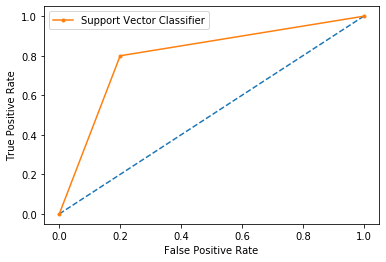

In [115]:
'''
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

ns_lbl = [0 for x in range(len(yspiraltest))]

SVCpipeline = Pipeline([
    ('hogify', HogTransformer(pixels_per_cell=(18,18),
                        cells_per_block=(3,3),
                        orientations=9, 
                        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(random_state=42, C = 0.0008, kernel = 'linear'))
])


model = SVCpipeline.fit(Xspiral, yspiral)

svc_lbl = model.predict(Xspiraltest)

ns_auc = roc_auc_score(yspiraltest, ns_lbl)
svc_auc = roc_auc_score(yspiraltest, svc_lbl)
print(svc_auc)

ns_fpr, ns_tpr, _ = roc_curve(yspiraltest, ns_lbl)
svc_fpr, svc_tpr, _ = roc_curve(yspiraltest, svc_lbl)

pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(svc_fpr, svc_tpr, marker='.', label='Support Vector Classifier')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()
'''

0.8000000000000002 0.8500000000000001


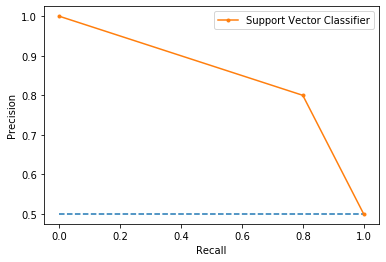

In [114]:
'''
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

svc_precision, svc_recall, _ = precision_recall_curve(yspiraltest, svc_lbl)
svc_f1 = f1_score(yspiraltest, svc_lbl)
svc_auc = auc(svc_recall, svc_precision)
print(svc_f1, svc_auc)


ns = 15 / len(yspiraltest)

pyplot.plot([0,1],[ns,ns], linestyle='--')
pyplot.plot(svc_recall, svc_precision, marker='.', label='Support Vector Classifier')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()
'''

In [90]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

SVCpipeline = Pipeline([
    ('hogify', HogTransformer(pixels_per_cell=(18,18),
                        cells_per_block=(3,3),
                        orientations=9, 
                        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(random_state=42, kernel='linear'))
])

grid = {
    'hogify__pixels_per_cell': 
    'classify__C': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5]    
}

paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SVCpipeline, paramGrid,
          Xspiral, yspiral, Xspiraltest, yspiraltest,
          metric = roc_auc_score, scoreLabel = 'AUC')
print(bestModel, bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [153]:
from sklearn.metrics import recall_score

SVCpipeline = Pipeline([
    ('hogify', HogTransformer()
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(random_state=42))
])

clf = SVCpipeline.fit(Xspiral, yspiral)

Xspiraltest, yspiraltest = extractXy(spiral_testing)
yspiraltest = [1 if (x == 'H' or x == 1) else 0 for x in yspiraltest]

yspiralpred = clf.predict(Xspiraltest)


print(np.array(yspiralpred == yspiraltest))
print('Accuracy: ', np.sum(yspiralpred == yspiraltest)/len(yspiraltest))
print('Recall: ', recall_score(yspiraltest, yspiralpred))

from sklearn.metrics import confusion_matrix
import pandas as pd

confusion_spiral = confusion_matrix(yspiraltest, yspiralpred)
df = pd.DataFrame(confusion_spiral)
df

[False False False False False False False False False False False False
 False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
Accuracy:  0.5
Recall:  0.0


,0,1
0,15,0
1,15,0


SVCpipeline = Pipeline([
    ('hogify', HogTransformer()
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(random_state=42))
])

clf = SVCpipeline.fit(Xspiral, yspiral)

Xspiraltest, yspiraltest = extractXy(spiral_testing)
yspiraltest = [1 if (x == 'H' or x == 1) else 0 for x in yspiraltest]

yspiralpred = clf.predict(Xspiraltest)


print(np.array(yspiralpred == yspiraltest))
print('Accuracy: ', np.sum(yspiralpred == yspiraltest)/len(yspiraltest))
print('Recall: ', recall_score(yspiraltest, yspiralpred))


from sklearn.metrics import confusion_matrix
import pandas as pd

confusion_spiral = confusion_matrix(yspiraltest, yspiralpred)
df = pd.DataFrame(confusion_spiral)
df

In [150]:
from keras import layers
from keras import models
import keras_metrics

model = models.Sequential()
model.add(layers.Conv2D(32,(5,5),activation='relu',
                       input_shape=(256,256,1)))
model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 252, 252, 32)      832       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 508032)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               130056448 
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 130,057,537
Trainable params: 130,057,537
Non-trainable params: 0
________________________________________

In [151]:
from keras.utils import to_categorical

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

Xspiral = Xspiral.reshape(72, 256, 256, 1)
Xspiral = Xspiral.astype('float32') / 255

yspiral = [1 if (x == 'H' or x == 1) else 0 for x in yspiral]



model.fit(Xspiral, yspiral,
         epochs=42,
         verbose=1
         )

Epoch 1/42
72/72 [==============================] - 11s 153ms/step - loss: 0.8089 - accuracy: 0.5000
Epoch 2/42
72/72 [==============================] - 6s 87ms/step - loss: 0.7623 - accuracy: 0.4583
Epoch 3/42
72/72 [==============================] - 7s 97ms/step - loss: 0.6829 - accuracy: 0.5000
Epoch 4/42
72/72 [==============================] - 6s 87ms/step - loss: 0.7000 - accuracy: 0.5000
Epoch 5/42
72/72 [==============================] - 6s 83ms/step - loss: 0.6994 - accuracy: 0.4722
Epoch 6/42
72/72 [==============================] - 6s 82ms/step - loss: 0.6941 - accuracy: 0.5139
Epoch 7/42
72/72 [==============================] - 6s 81ms/step - loss: 0.6933 - accuracy: 0.4722
Epoch 8/42
72/72 [==============================] - 6s 81ms/step - loss: 0.6927 - accuracy: 0.6389
Epoch 9/42
72/72 [==============================] - 6s 82ms/step - loss: 0.6928 - accuracy: 0.5556
Epoch 10/42
72/72 [==============================] - 6s 81ms/step - loss: 0.6936 - accuracy: 0.4028
Epoch 1

In [152]:
Xspiraltest = Xspiraltest.reshape(30, 256, 256, 1)
yspiraltest = [1 if x == ('H' or 1) else 0 for x in yspiraltest]
print(yspiraltest)

test_loss, test_acc = model.evaluate(Xspiraltest, yspiraltest)
print(test_loss)
print(test_acc)

pred = model.predict_classes(Xspiraltest)
print(pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
30/30 [==============================] - 1s 22ms/step
0.0
1.0
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
